In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

In [24]:
def plot_one_box(box, ax, alpha=0.5):
    ax.plot((box[0], box[2]), (box[1], box[1]), c='r', alpha=alpha)
    ax.plot((box[0], box[0]), (box[1], box[3]), c='r', alpha=alpha)
    ax.plot((box[0], box[2]), (box[3], box[3]), c='r', alpha=alpha)
    ax.plot((box[2], box[2]), (box[3], box[1]), c='r', alpha=alpha)

In [9]:
def generate_anchor_base(base_size, anchor_scale, anchor_ratio):
    """
    VGG16得到的featuremap是原图的1/16，featuremap上每个像素相当于原图的16个像素，因此最小的anchor的面积为16*16.
    以原点为圆心，按照不同的scale和ratio分别生成9个不同大小的anchor。
    :param base_size:
    :param anchor_scale:
    :param anchor_ratio:
    :return: [xmin, ymin, xmax, ymax]
    """
    anchors = np.empty(shape=[len(anchor_scale), len(anchor_ratio), 4])
    for i, scale in enumerate(anchor_scale):
        for j, ratio in enumerate(anchor_ratio):
            w, h = scale * np.sqrt(ratio), scale * np.sqrt(1 / ratio)
            anchors[i, j, 0] = 0 - (w) / 2 + (base_size-1) / 2  # '+ base_size / 2'保证最小的anchor的面积为16*16
            anchors[i, j, 1] = 0 - (h) / 2 + (base_size-1) / 2
            anchors[i, j, 2] = 0 + (w) / 2 + (base_size-1) / 2
            anchors[i, j, 3] = 0 + (h) / 2 + (base_size-1) / 2
    return anchors.reshape(-1, 4)


def _enumerate_shift_anchors(height, width, step, base_anchors):
    """
    按照规则计算得到指定面积图像上对应像素的坐标，并将base_anchors的中心移动到该坐标
    (为面积为height*height的图像，按照步长step为图像上对应的像素生成坐标，然后将base_anchors的中心移动到生成的每个坐标上)
    :param height:
    :param width:
    :param step: 16(vgg16得到的特征图是原图像长宽的1/16)
    :param base_anchors: shape: [9, 4] / format: [xmin, ymin, xmax, ymax]
    :return: 返回的anchor的scale与输入图片是一样的([max_size=1000, min_size=600])
    """
    y = np.arange(0, height*step, step)
    x = np.arange(0, width*step, step)
    coor_y, coor_x = np.meshgrid(y, x)
    # grid_coor shape: [(h/16)*(w/16), 4] / format: [xmin, ymin, xmax, ymax]
    grid_coor = np.stack((coor_x.ravel(), coor_y.ravel(), coor_x.ravel(), coor_y.ravel()), axis=1)
    # broadcast: [1, 9, 4] & [(h/16)*(w/16), 1, 4] -> [(h/16)*(w/16), 9, 4]
    rpn_anchors = base_anchors + grid_coor[:, None, :]
    return rpn_anchors.astype(np.float32)

## anchors center coordinate

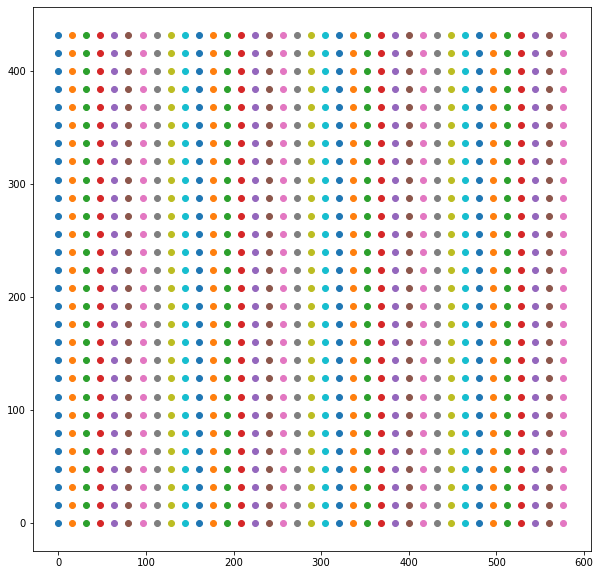

In [10]:
y = np.arange(0, 28*16, 16)
x = np.arange(0, 37*16, 16)
coor_y, coor_x = np.meshgrid(y, x)
grid_coor = np.stack((coor_x.ravel(), coor_y.ravel(), coor_x.ravel(), coor_y.ravel()), axis=1)

plt.figure(figsize=[10, 10])
for xs, ys in zip(coor_x, coor_y):
    plt.scatter(xs, ys)
plt.show()

In [11]:
base_anchor = generate_anchor_base(16, [128, 256, 512], [0.5, 1, 2])
anchors = _enumerate_shift_anchors(28, 37, 16, base_anchor)

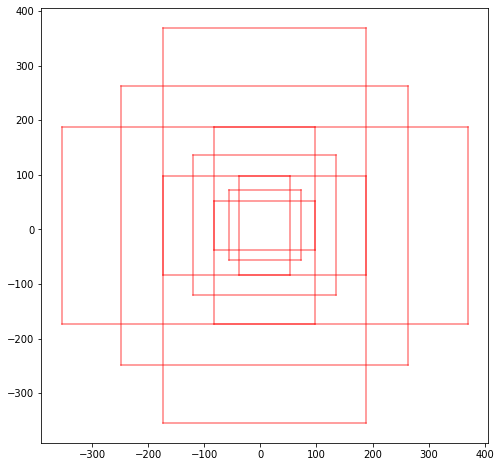

In [12]:
fig, ax = plt.subplots(1, figsize=[8, 8])

for box in base_anchor:
    plot_one_box(box, ax)
    
plt.show()

In [13]:
print('base:\n', np.round(base_anchor))
print('grid:', grid_coor[1])
print('anchor', anchors[1])

base:
 [[ -38.  -83.   53.   98.]
 [ -56.  -56.   72.   72.]
 [ -83.  -38.   98.   53.]
 [ -83. -174.   98.  189.]
 [-120. -120.  136.  136.]
 [-174.  -83.  189.   98.]
 [-174. -355.  189.  370.]
 [-248. -248.  264.  264.]
 [-355. -174.  370.  189.]]
grid: [ 0 16  0 16]
anchor [[ -37.754833  -67.00967    52.754833  114.00967 ]
 [ -56.5       -40.5        71.5        87.5     ]
 [ -83.00967   -21.754833   98.00967    68.75484 ]
 [ -83.00967  -157.51933    98.00967   204.51933 ]
 [-120.5      -104.5       135.5       151.5     ]
 [-173.51933   -67.00967   188.51933   114.00967 ]
 [-173.51933  -338.53867   188.51933   385.53867 ]
 [-248.5      -232.5       263.5       279.5     ]
 [-354.53867  -157.51933   369.53867   204.51933 ]]


## all anchors

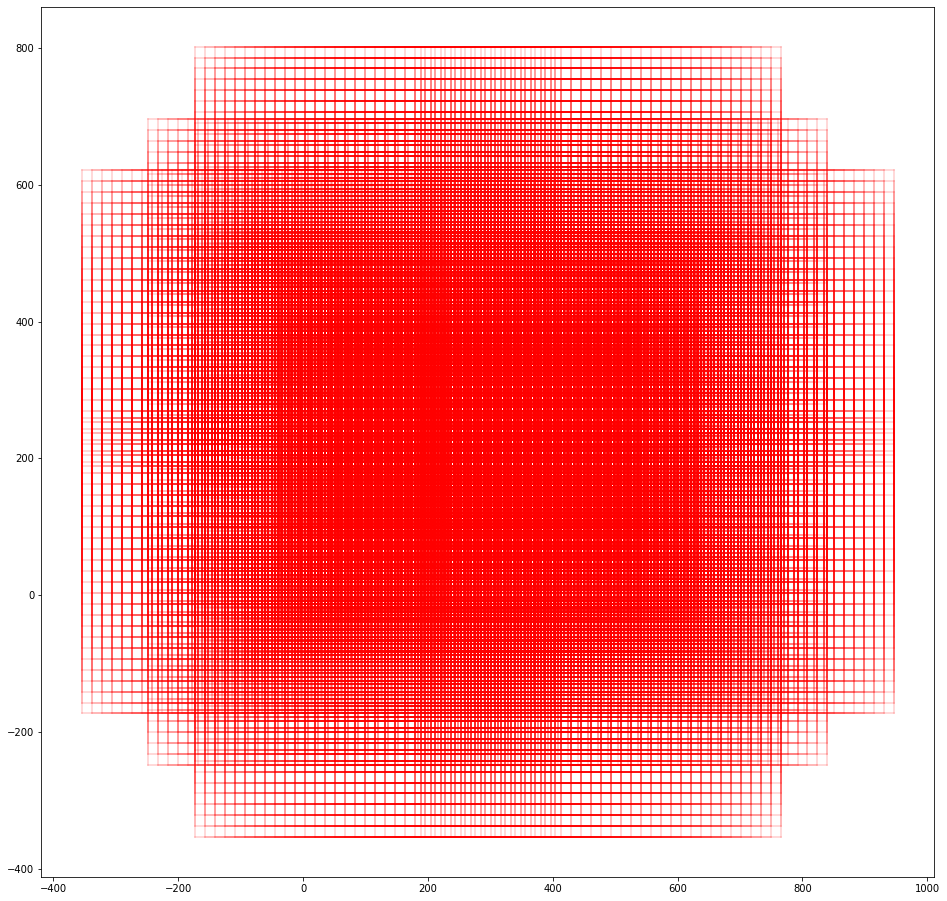

In [19]:
fig, ax = plt.subplots(1, figsize=[16, 16])

for boxes in anchors:
    for box in boxes:
        plot_one_box(box, ax, 0.2)
    
plt.show()

In [14]:
len(anchors) * 9

9324

In [21]:
a = np.random.rand(10, 4)
(a[:, 0] < a[:, 1]).all()

False

In [22]:
a

array([[0.98648422, 0.71710165, 0.97771439, 0.59803217],
       [0.10735336, 0.12696856, 0.05417515, 0.11527022],
       [0.74989289, 0.65446401, 0.07462422, 0.12222061],
       [0.72845621, 0.2730803 , 0.63595494, 0.9888129 ],
       [0.22218201, 0.01558399, 0.73125708, 0.99993038],
       [0.84297867, 0.51500062, 0.7769592 , 0.16454093],
       [0.59540283, 0.15869635, 0.16483856, 0.76301789],
       [0.52599502, 0.12153756, 0.19230179, 0.13630804],
       [0.14501475, 0.74043774, 0.5716155 , 0.32589681],
       [0.47496414, 0.54401095, 0.44914687, 0.21931861]])

In [28]:
mask = a[:, 0]>0.5
mask

array([ True, False,  True,  True, False,  True,  True,  True, False,
       False])

In [31]:
b = a[mask, :]

In [32]:
c = a[mask]

In [33]:
b == c

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [34]:
c.flags.owndata

True

In [35]:
b.flags.owndata

True

In [30]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

if __name__ == '__main__':
    import time
    t = time.time()
    a = generate_anchors()

In [31]:
a, np.round(base_anchor)

(array([[ -84.,  -40.,   99.,   55.],
        [-176.,  -88.,  191.,  103.],
        [-360., -184.,  375.,  199.],
        [ -56.,  -56.,   71.,   71.],
        [-120., -120.,  135.,  135.],
        [-248., -248.,  263.,  263.],
        [ -36.,  -80.,   51.,   95.],
        [ -80., -168.,   95.,  183.],
        [-168., -344.,  183.,  359.]]), array([[ -38.,  -83.,   53.,   98.],
        [ -56.,  -56.,   72.,   72.],
        [ -83.,  -38.,   98.,   53.],
        [ -83., -174.,   98.,  189.],
        [-120., -120.,  136.,  136.],
        [-174.,  -83.,  189.,   98.],
        [-174., -355.,  189.,  370.],
        [-248., -248.,  264.,  264.],
        [-355., -174.,  370.,  189.]]))

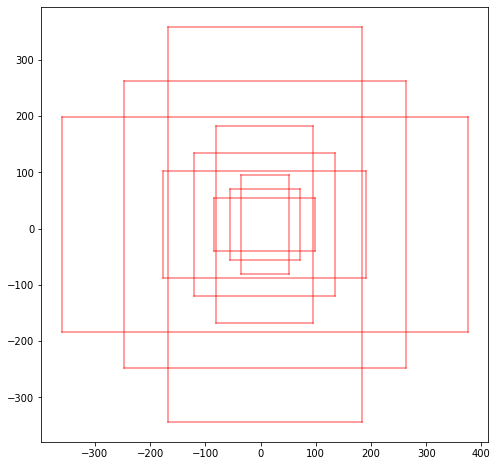

In [27]:
fig, ax = plt.subplots(1, figsize=[8, 8])
for box in a:
    plot_one_box(box, ax)

In [32]:
def xyxy2xywh(boxes):
    """
    :param boxes:
        [[xmin, ymin, xmax, ymax], ...]
    :return:
        [[center_x, center_y, w, h], ...]
    """
    assert isinstance(boxes, np.ndarray)
    assert boxes.ndim == 2

    ws = boxes[:, 2] - boxes[:, 0] + 1
    hs = boxes[:, 3] - boxes[:, 1] + 1
    ctr_x = boxes[:, 0] + ws / 2
    ctr_y = boxes[:, 1] + hs / 2

    xywh = np.stack([ctr_x, ctr_y, ws, hs], axis=1)
    return xywh



bboxes = np.random.rand(10, 4) * 20
xyxy2xywh(bboxes)

array([[ 16.81772076,   5.50918169,   2.41820268,   1.33549645],
       [  7.4179607 ,  10.42584811,   1.69150956,   1.75760403],
       [  7.0918899 ,   9.40541577,  -9.93806546,  15.57212239],
       [  2.76558608,  14.83832766,  -1.00995904,   9.41569449],
       [ 15.75799637,   4.91032263,  -8.44165115,  -2.45350704],
       [  3.77276258,   8.75205319,  -2.92058243,  16.58286567],
       [  7.51091771,  12.58894507,  10.32187365,  -9.34679472],
       [  5.05179622,  17.65522148,  -3.00261055,  -3.18380296],
       [  9.12445325,  12.97445721, -15.09563694,  10.22150772],
       [  3.36040068,  19.74963542,   0.04414185,   1.60792822]])

In [39]:
def iou_general(bbox1, bbox2):
    """
    :param bbox1: [[xmin, ymin, xmax, ymax], ...]
    :param bbox2: [[xmin, ymin, xmax, ymax], ...]
    :return:
    """
    assert isinstance(bbox1, np.ndarray)
    assert isinstance(bbox2, np.ndarray)
    assert bbox1.shape[-1] == 4
    assert bbox2.shape[-1] == 4

    M = len(bbox1)
    N = len(bbox2)

    bbox1_area = np.prod(bbox1[..., [2, 3]] - bbox1[..., [0, 1]] + 1, axis=-1)
    bbox2_area = np.prod(bbox2[..., [2, 3]] - bbox2[..., [0, 1]] + 1, axis=-1)

    intersection_ymax = np.minimum(bbox1[..., 3], bbox2[..., 3])
    intersection_xmax = np.minimum(bbox1[..., 2], bbox2[..., 2])
    intersection_ymin = np.maximum(bbox1[..., 1], bbox2[..., 1])
    intersection_xmin = np.maximum(bbox1[..., 0], bbox2[..., 0])

    intersection_w = np.maximum(0., intersection_xmax - intersection_xmin + 1)
    intersection_h = np.maximum(0., intersection_ymax - intersection_ymin + 1)
    intersection_area = intersection_w * intersection_h
    ious = intersection_area / (bbox1_area + bbox2_area - intersection_area)
    if M != N:
        assert ious.shape[-2:] == (M, N) or ious.shape[-2:] == (N, M)
    else:
        assert len(ious) == M
    return ious

box1 = np.random.rand(10, 4) * 20
box2 = np.random.rand(10, 4) * 20
iou_general(box1, box2)

array([-0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.])

In [41]:
a = [5,5,1,2,3]
{v: idx for idx, v in enumerate(a)}

{5: 1, 1: 2, 2: 3, 3: 4}

In [44]:
grid_x = np.arange(13, dtype=np.float32)
grid_y = np.arange(13, dtype=np.float32)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

xy_offset = np.stack([grid_y.ravel(), grid_x.ravel()], axis=1)

In [45]:
xy_offset

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 0.,  4.],
       [ 0.,  5.],
       [ 0.,  6.],
       [ 0.,  7.],
       [ 0.,  8.],
       [ 0.,  9.],
       [ 0., 10.],
       [ 0., 11.],
       [ 0., 12.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 1., 11.],
       [ 1., 12.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 2.,  5.],
       [ 2.,  6.],
       [ 2.,  7.],
       [ 2.,  8.],
       [ 2.,  9.],
       [ 2., 10.],
       [ 2., 11.],
       [ 2., 12.],
       [ 3.,  0.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  3.],
       [ 3.,  4.],
       [ 3.,  5.],
       [ 3.,  6.],
       [ 3.,  7.],
       [ 3.,  8.],
       [ 3.,  9.],
       [ 3., 10.],
       [ 3., 11.],
       [ 3., 12.],
       [ 4.,

In [62]:
import torch
a = torch.rand(10, 4)
(a[:, [2, 3]] >= a[:, [0, 1]]).all()

tensor(False)

In [69]:
a = torch.rand(10)
print(a)
a[a.le(0.5)] = 0
a

tensor([0.7673, 0.4586, 0.6356, 0.0968, 0.4468, 0.5693, 0.0432, 0.6262, 0.0908,
        0.4828])


tensor([0.7673, 0.0000, 0.6356, 0.0000, 0.0000, 0.5693, 0.0000, 0.6262, 0.0000,
        0.0000])